In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial.distance
import scipy

In [2]:
GT = np.genfromtxt('ds0_Groundtruth.dat', skip_header = 3, skip_footer = 0, names = True, dtype = None, delimiter = ' ' , usecols = [0, 3, 5, 7])
Odom = np.genfromtxt('ds0_Odometry.dat', skip_header = 3, skip_footer = 0, names = True, dtype = None, delimiter = ' ' , usecols = [0,4,5])

In [3]:
start_time = GT[0][0]
for i in range(len(GT)):
    GT[i][0]-= start_time
for i in range(len(Odom)):
    Odom[i][0]-=start_time

In [4]:
j = 1
k = 1
align = []

for i in range (len(GT)):
    match = 0
    while (match == 0 and j < len(GT) and k < len(Odom)-1):
        if (GT[j][0] - Odom[k][0] > 0 and GT[j][0] - Odom[k+1][0]<= 0):
            align.append((GT[j], Odom[k]))
            j+=1
            match = 1
        else:
            k+=1

In [6]:
train_in = []
train_out = []

test_in = []
test_out = []

val_in = []
val_out = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0

for i in range(len(align) - 2):
    
    dt_in = align[i+1][0][0] - align[i][0][0]
    
    x_in = align[i+1][0][1] - align[i][0][1]
    y_in = align[i+1][0][2] - align[i][0][2]
    theta_in = align[i+1][0][3] - align[i][0][3]
    
    v_in = align[i+1][1][1] - align[i][1][1]
    w_in = align[i+1][1][2] - align[i][1][2]

    dt_out = align[i+2][0][0] - align[i+1][0][0] # (t+1) - (t)
    
    x_out = align[i+2][0][1] - align[i+1][0][1]
    y_out = align[i+2][0][2] - align[i+1][0][2]
    theta_out = align[i+2][0][3] - align[i+1][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        test_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        val_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
        ind_count+=1
    else:
        train_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        train_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
    

In [7]:
train_in2 = []
train_out2 = []

test_in2 = []
test_out2 = []

val_in2 = []
val_out2 = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0

for i in range(len(align) - 2):
    
    dt_in = align[i+1][0][0] - align[i][0][0]
    
    x_in = align[i+1][0][1] - align[i][0][1]
    y_in = align[i+1][0][2] - align[i][0][2]
    theta_in = align[i+1][0][3] - align[i][0][3]
    
    v = np.sqrt(((x_in/dt_in)**2)+((y_in/dt_in)**2))
    w = theta_in/dt_in
    
    v_in = align[i+1][1][1] - align[i][1][1]
    w_in = align[i+1][1][2] - align[i][1][2]
    
    del_v = np.abs(v - v_in)
    del_w = np.abs(w - w_in)

    dt_out = align[i+2][0][0] - align[i+1][0][0] # (t+1) - (t)
    
    x_out = align[i+2][0][1] - align[i+1][0][1]
    y_out = align[i+2][0][2] - align[i+1][0][2]
    theta_out = align[i+2][0][3] - align[i+1][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in2.append([del_v, del_w, dt_out])
        test_out2.append([x_out, y_out, theta_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in2.append([del_v, del_w, dt_out])
        val_out2.append([x_out, y_out, theta_out])
        ind_count+=1
    else:
        train_in2.append([del_v, del_w, dt_out])
        train_out2.append([x_out, y_out, theta_out])
    

In [8]:
def RBF_1d(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    K = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            d = np.abs(X1[i] - X2[j])
            K[i][j] = var*np.exp(-(d**2)/(2*(l**2)))
            #K[j][i] = var*np.exp(-(d**2)/(2*(l**2)))
    return K

In [9]:
def GP_1d(x_in, y_out, x_test, l, var):
    '''
        x_in = 1D array of training input
        y_out = 1D array of training output
        x_test = single point of test input
    '''
    # compute kernel, covar of training input
    Kxx = RBF_1d(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + 1e-5*np.eye(x_in.shape[0])) # add noise
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html
    
    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
    
    # compute covar
    Kxxt = RBF_1d(x_in, x_test, l, var)

    # compute covar of test data
    Kxtxt = RBF_1d(x_test, x_test, l, var)
    
    # compute posterior mean
    mu_post = np.matmul(Kxxt.T, alpha)    
    
    #compute poserior covar
    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    #sigma = Kxtxt - np.dot(Kxxt, np.linalg.inv(Kxx).dot(Kxxt))
    # https://blog.dominodatalab.com/fitting-gaussian-process-models-python
    
    #mu_post = np.dot((scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T), y_out)
    #mu_post = (scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T) * y_out
    #sigma_post = Kxtxt - np.dot((scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T), Kxxt) 
    # https://peterroelants.github.io/posts/gaussian-process-tutorial/
    
    return mu_post, sigma_post

In [143]:
def RBF_nd(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    d = scipy.spatial.distance.cdist(X1, X2, 'cityblock')
    K = var * np.exp(-(d**2)/(2*(l**2)))
    return K
    
def GP(x_in, y_out, x_test, l, var, noise, prior_mean):
    #prior_mean = 0
    #noise = 1e-5
    
    Kxx = RBF_nd(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    Kxxt = RBF_nd(x_in, x_test, l, var)

    Kxtxt = RBF_nd(x_test, x_test, l, var)

    mu_post = np.matmul(Kxxt.T, alpha)

    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    return mu_post, sigma_post
 
def log_like(x_in, y_out, x_test, l, var, noise):
    Kxx = RBF_nd(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    return MLL

def log_like_1d(x_in, y_out, x_test, l, var):
    Kxx = RBF_1d(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + 1e-5*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    return MLL
    
def least_squares(y_pred, y_true):
    total = 0
    for i in range(len(y_pred)):
        total+=((y_pred[i] - y_true[i])**2)
    return total

#def grad_descent():
    
def gradient_descent(loss_func, alpha_choice, max_its, params):
    g_flat, unflatten, w = flatten_func(loss_func, params) # note here the output 'w' is also flattened

    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        params = params - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w))  
    return weight_history[-1],cost_history[-1]

#def optimize():
        
#def log_max():

def MSE(mean_out, y_true):
    total = 0
    for i in range(len(mean_out)):
        total+=((mean_out[i][0] - y_true[i])**2)
    return total

def neg_log_prob(mean_out, y_true, post_var):
    noise = 1e-5*np.eye(post_var.shape[0])
    pred_var = post_var + noise
    #print((2*np.pi*pred_var))
    return .5*np.log(2*np.pi*(np.abs(pred_var))) + ((y_true-mean_out)**2)/(2*pred_var)

https://blog.dominodatalab.com/fitting-gaussian-process-models-python

In [11]:
'''
train_in = []
train_out = []

test_in = []
test_out = []

val_in = []
val_out = []
'''

train_in2 = np.array(train_in2)
train_in2.shape

(77673, 3)

In [55]:
x_train = train_in2[0:100]
x_test = test_in2[0:10]
y_train = np.zeros(100)
y_true = np.zeros(10)

for i in range(100):
    y_train[i] = train_out2[i][0]
    
for i in range(10):
    y_true[i] = test_out2[i][0]

print('length scale = 1')
    
mu, sigma = GP(x_train, y_train, x_test, 1, 0.1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 1, 0.1, 1e-1)
print(LL[0], '\n')

print('length scale = 10')

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print(LL[0], '\n')

print('length scale = 100')

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print(LL[0], '\n')

print('length scale = 1000')

mu, sigma = GP(x_train, y_train, x_test, 1000, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 1000, 0.1, 1e-1)
print(LL[0], '\n')

print('length scale = 10000')

mu, sigma = GP(x_train, y_train, x_test, 10000, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 10000, 0.1, 1e-1)
print(LL[0])

length scale = 1
0.043062379872448445
20.054450217057592 

length scale = 10
0.0005285748867809022
20.91056682590535 

length scale = 100
0.06370714927998476
20.927666157237752 

length scale = 1000
0.0003104285982949284
20.927839567382975 

length scale = 10000
0.010562028320811793
20.92784130173112


<ipython-input-55-86f1df645d83>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)
<ipython-input-55-86f1df645d83>:27: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)
<ipython-input-55-86f1df645d83>:38: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


In [56]:
x_train = train_in2[0:1000]
x_test = test_in2[0:100]
y_train = np.zeros(1000)
y_true = np.zeros(100)

for i in range(1000):
    y_train[i] = train_out2[i][0]
    
for i in range(100):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('1000 training points, 100 testing points')

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print(LL[0], '\n')

1000 training points, 100 testing points
0.06566715132835642
228.8964549583484 



<ipython-input-56-0f04d7c490db>:14: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


In [57]:
x_train = train_in2[0:10000]
x_test = test_in2[0:1000]
y_train = np.zeros(10000)
y_true = np.zeros(1000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(1000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 1000 testing points')

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print(LL[0], '\n')

<ipython-input-57-76b631eece4b>:14: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 1000 testing points
0.03092153511167252
2318.56571694551 



In [58]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
import matplotlib.pyplot as plt
import numpy as np

# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:100], y_train[0:100])
 
# Predict mean
y_hat, y_sigma = gpr.predict(x_test[0:10], return_std=True)

'''
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# Squeeze data
x_train = np.squeeze(x_train)
y_train = np.squeeze(y_train)
x_test = np.squeeze(x_test)
y_true = np.squeeze(y_true)

# Plot the training data
ax.scatter(x_train, y_train)
#ax.scatter(x_test, y_test, color='red')


# Plot predictive means as blue line
#ax.plot(x_test, y_hat, 'b')

# Shade between the lower and upper confidence bounds
lower = x_test - y_sigma
upper = x_test + y_sigma
ax.fill_between(x_test, lower, upper, alpha=0.5)
ax.set_ylim([-3, 3])
plt.title("GPR Model Predictions")
plt.show()
'''

print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

<bound method BaseEstimator.get_params of GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         random_state=0)>
464.47284290058104
RBF(length_scale=1e+05) + WhiteKernel(noise_level=1e-05)


/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [59]:
# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:1000], y_train[0:1000])
 
# Predict mean
y_hat, y_sigma = gpr.predict(x_test[0:100], return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

4754.386652043086
RBF(length_scale=21.6) + WhiteKernel(noise_level=1e-05)


/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [60]:
# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:1000], y_train[0:1000])
 
# Predict mean
y_hat, y_sigma = gpr.predict(x_test[0:1000], return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

4754.386652043086
RBF(length_scale=21.6) + WhiteKernel(noise_level=1e-05)


/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
            )

In [115]:
mu, sigma = GP(x_train[0:100], y_train[0:100], x_test[0:10], 21.6, .00001, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(10,), sigma)

print(least_squares(y_predict, y_true))

LL = log_like(x_train, y_train, x_test, 21.6, 0.00001, 1e-1)
print(LL[0])

0.00019495051228896152
2323.1935026559586


Text(0, 0.5, '∆x')

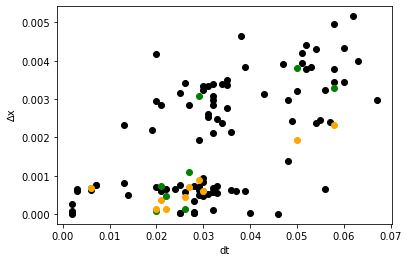

In [100]:
for i in range(100):
    plt.scatter(x_train[i][2], np.abs(y_train[i]), color = 'black')
for i in range(10):
    #plt.scatter(x_test[i][2], np.abs(mu[i]), color = 'red')
    plt.scatter(x_test[i][2], np.abs(y_true[i]), color = 'green')
    #plt.scatter(x_test[i][2], np.abs(y_predict[i]), color = 'blue')
    plt.scatter(x_test[i][2], np.abs(y_hat[i]), color = 'orange')
plt.xlabel('dt')
plt.ylabel('∆x')

Text(0, 0.5, '∆x')

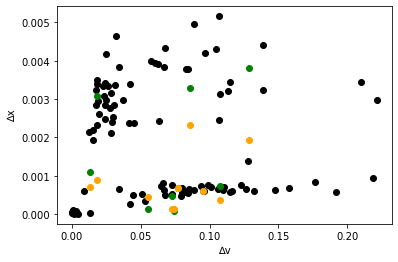

In [101]:
for i in range(100):
    plt.scatter(x_train[i][0], np.abs(y_train[i]), color = 'black')
for i in range(10):
    #plt.scatter(x_test[i][0], np.abs(mu[i]), color = 'red')
    plt.scatter(x_test[i][0], np.abs(y_true[i]), color = 'green')
    #plt.scatter(x_test[i][0], np.abs(y_predict[i]), color = 'blue')
    plt.scatter(x_test[i][0], np.abs(y_hat[i]), color = 'orange')
plt.xlabel('∆v')
plt.ylabel('∆x')

Text(0, 0.5, '∆x')

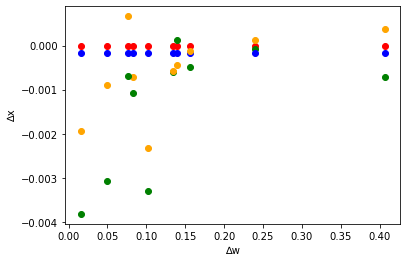

In [102]:
for i in range(100):
    #plt.scatter(x_train[i][1], (y_train[i]), color = 'black')
    pass
for i in range(10):
    plt.scatter(x_test[i][1], (mu[i]), color = 'red')
    plt.scatter(x_test[i][1], (y_true[i]), color = 'green')
    plt.scatter(x_test[i][1], (y_predict[i]), color = 'blue')
    plt.scatter(x_test[i][1], (y_hat[i]), color = 'orange')
plt.xlabel('∆w')
plt.ylabel('∆x')

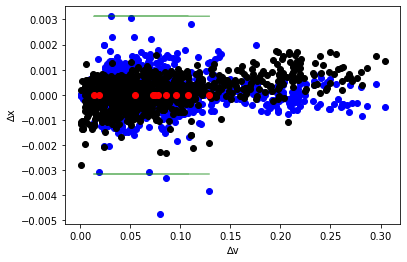

In [139]:
plt.scatter(np.array(x_test).T[0], y_true, color = 'blue')
plt.scatter(np.array(x_test).T[0], y_hat, color = 'black')
plt.scatter(np.array(x_test).T[0][0:10], mu, color = 'red')
plt.xlabel('∆v')
plt.ylabel('∆x')

plt.plot(np.array(x_test).T[0][0:10], L, alpha=0.5, color = 'green')
plt.plot(np.array(x_test).T[0][0:10], U, alpha=0.5, color = 'green')

In [88]:
mu_lin, sigma_lin = GP_1d(x_train.T[0][0:1000], y_train[0:1000], np.linspace(0,0.35,100), 21.6, .00001)

y_predict = np.random.multivariate_normal(mu_lin.reshape(100,), sigma_lin)

In [91]:
std_lin = np.sqrt(np.diag(sigma_lin))
#y_predict

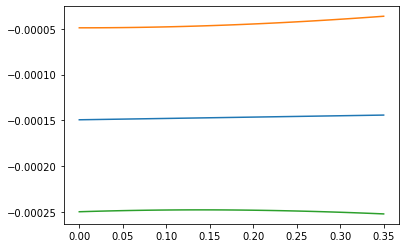

In [92]:
#plt.scatter(np.array(x_test).T[0], y_true, color = 'blue')
#plt.scatter(np.array(x_test).T[0], y_hat, color = 'black')
#plt.scatter(np.array(x_test).T[0][0:10], mu, color = 'red')
plt.plot(np.linspace(0,0.35,100), mu_lin)
plt.plot(np.linspace(0,0.35,100), mu_lin+std_lin)
plt.plot(np.linspace(0,0.35,100), mu_lin-std_lin)

In [95]:
# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train.T[0][0:1000].reshape(-1,1), y_train[0:1000])
 
# Predict mean
y_hat_lin, y_sigma_lin = gpr.predict(np.linspace(0,.35,100).reshape(-1,1), return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

4729.40413432204
RBF(length_scale=363) + WhiteKernel(noise_level=1e-05)


/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


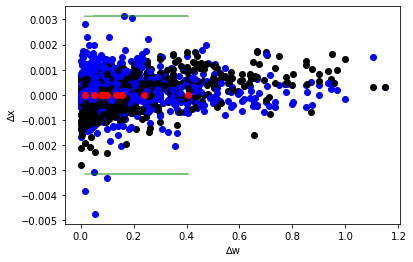

In [136]:
for i in range(len(x_test)):
    if i != 14:
        plt.scatter(np.array(x_test)[i][1], y_true[i], color = 'blue')
        plt.scatter(np.array(x_test)[i][1],y_hat[i], color = 'black')

#plt.scatter(np.array(x_test).T[1], y_true)
#plt.scatter(np.array(x_test).T[1], y_hat)
plt.scatter(np.array(x_test).T[1][0:10], mu, color = 'red')
plt.xlabel('∆w')
plt.ylabel('∆x')

plt.plot(np.array(x_test).T[1][0:10], L, alpha=0.5, color = 'green')
plt.plot(np.array(x_test).T[1][0:10], U, alpha=0.5, color = 'green')

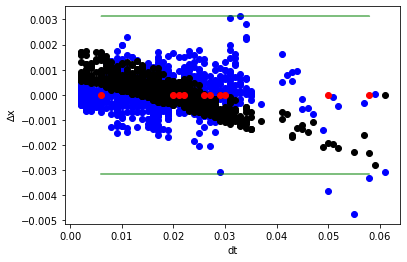

In [135]:
plt.scatter(np.array(x_test).T[2], y_true, color = 'blue')
plt.scatter(np.array(x_test).T[2], y_hat, color = 'black')
plt.scatter(np.array(x_test).T[2][0:10], mu, color = 'red')

#lower = mu - sigma
#upper = mu + sigma

std1 = np.sqrt(np.diag(sigma))

lower = mu-std1
upper = mu+std1

L = []
U = []

for i in range(10):
    #L.append(lower[i][i])
    #U.append(upper[i][i])
    L.append(lower[i])
    U.append(upper[i])
#plt.fill_between(np.array(x_test).T[2][0:10], L, U, alpha=0.5, color = 'red')
#plt.fill_between(np.array(x_test).T[2][0:10], 2*sigma[0][0])
plt.xlabel('dt')
plt.ylabel('∆x')
plt.plot(np.array(x_test).T[2][0:10], L, alpha=0.5, color = 'green')
plt.plot(np.array(x_test).T[2][0:10], U, alpha=0.5, color = 'green')

In [25]:
y_train2 = np.zeros(10000)
y_true2 = np.zeros(1000)

for i in range(10000):
    y_train2[i] = train_out2[i][2]
    
for i in range(1000):
    y_true2[i] = test_out2[i][2]

In [44]:
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:1000], y_train2[0:1000])
 
# Predict mean
y_hat2, y_sigma2 = gpr.predict(x_test[0:1000], return_std=True)
y_hat2, y_cov2 = gpr.predict(x_test[0:1000], return_cov=True)

#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

195.85725481445843
RBF(length_scale=3.55e+04) + WhiteKernel(noise_level=0.0392)


In [48]:
y_sigma2.shape

(1000,)

In [47]:
y_cov2.shape

(1000, 1000)

In [27]:
mu2, sigma2 = GP(x_train[0:100], y_train2[0:100], x_test[0:10], 10000, .01, 1e-1, 0)

y_predict2 = np.random.multivariate_normal(mu2.reshape(10,), sigma2)

print(least_squares(y_predict2, y_true2))

LL2 = log_like(x_train, y_train2, x_test, 10000, 0.01, 1e-1)
print(LL2[0])

0.0272361242517912
2320.085736047862


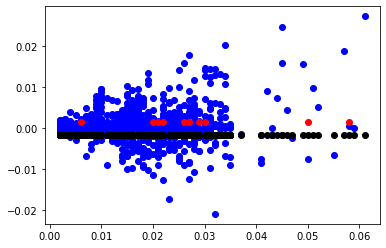

In [28]:
plt.scatter(np.array(x_test).T[2], y_true2, color = 'blue')
plt.scatter(np.array(x_test).T[2], y_hat2, color = 'black')
plt.scatter(np.array(x_test).T[2][0:10], mu2, color = 'red')

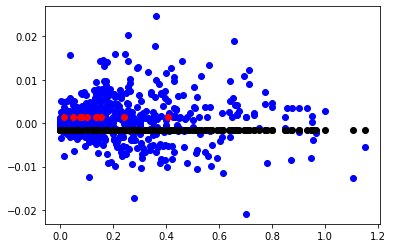

In [29]:
for i in range(len(x_test)):
    if i != 14:
        plt.scatter(np.array(x_test)[i][1], y_true2[i], color = 'blue')
        plt.scatter(np.array(x_test)[i][1],y_hat2[i], color = 'black')
plt.scatter(np.array(x_test).T[1][0:10], mu2, color = 'red')

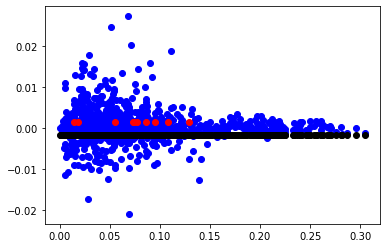

In [30]:
plt.scatter(np.array(x_test).T[0], y_true2, color = 'blue')
plt.scatter(np.array(x_test).T[0], y_hat2, color = 'black')
plt.scatter(np.array(x_test).T[0][0:10], mu2, color = 'red')

try changing data set so all points are absolute valued

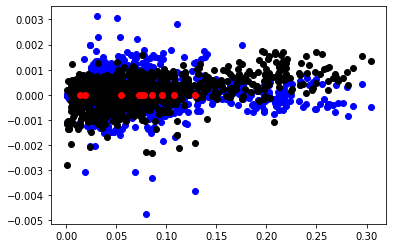

In [31]:
plt.scatter(np.array(x_test).T[0], y_true, color = 'blue')
plt.scatter(np.array(x_test).T[0], y_hat, color = 'black')
plt.scatter(np.array(x_test).T[0][0:10], mu, color = 'red')
X_plot = np.linspace(0, 0.3, 100)[:, None]

In [52]:
std1 = np.sqrt(np.diag(sigma))
print(std1)

[0.00314659 0.00314659 0.00314659 0.00314659 0.00314659 0.00314659
 0.00314659 0.00314659 0.00314659 0.00314659]


In [54]:
y_sigma[0:10]

array([0.00316493, 0.00316737, 0.00316641, 0.0031677 , 0.003169  ,
       0.00316472, 0.00317624, 0.0031643 , 0.00316615, 0.0031785 ])

In [145]:
def GP2(x_in, y_out, x_test, l, var, noise, prior_mean):
    #prior_mean = 0
    #noise = 1e-5
    
    Kxx = RBF_nd(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    Kxxt = RBF_nd(x_in, x_test, l, var)

    Kxtxt = RBF_nd(x_test, x_test, l, var)

    mu_post = np.matmul(Kxxt.T, alpha)

    v = scipy.linalg.solve_triangular(L, Kxxt, lower=True)
    sigma_post = Kxtxt - np.matmul(v.T, v)
    
    return mu_post, sigma_post

In [146]:
x_train = train_in2[0:1000]
x_test = test_in2[0:100]
y_train = np.zeros(1000)
y_true = np.zeros(100)

for i in range(1000):
    y_train[i] = train_out2[i][0]
    
for i in range(100):
    y_true[i] = test_out2[i][0]

mu_test, sigma_test = GP(x_train, y_train, x_test, 20, .1, 1e-1, 0)
mu_test2, sigma_test2 = GP2(x_train, y_train, x_test, 20, .1, 1e-1, 0)

y_predict_test = np.random.multivariate_normal(mu_test.reshape(len(x_test)), sigma_test)
y_predict_test2 = np.random.multivariate_normal(mu_test2.reshape(len(x_test)), sigma_test2)

#print('1000 training points, 100 testing points')

#print(least_squares(y_predict, y_true))

#LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
#print(LL[0], '\n')

<ipython-input-146-6f4168d97659>:15: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict_test = np.random.multivariate_normal(mu_test.reshape(len(x_test)), sigma_test)
<ipython-input-146-6f4168d97659>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict_test2 = np.random.multivariate_normal(mu_test2.reshape(len(x_test)), sigma_test2)


In [147]:
mu_test[0:10], mu_test2[0:10]

(array([-0.0001497 , -0.00018463, -0.00011849, -0.00019008, -0.00017635,
        -0.00016442, -0.00018249, -0.00017015, -0.00016914, -0.00019952]),
 array([-0.0001497 , -0.00018463, -0.00011849, -0.00019008, -0.00017635,
        -0.00016442, -0.00018249, -0.00017015, -0.00016914, -0.00019952]))

In [149]:
std_test = np.sqrt(np.diag(sigma_test))
std_test2 = np.sqrt(np.diag(sigma_test2))

In [152]:
std_test[0:10], std_test2[0:10]

(array([0.01000557, 0.01055788, 0.01038147, 0.01069977, 0.01045076,
        0.01011824, 0.01044305, 0.01018176, 0.01021958, 0.01101493]),
 array([0.01000557, 0.01055788, 0.01038147, 0.01069977, 0.01045076,
        0.01011824, 0.01044305, 0.01018176, 0.01021958, 0.01101493]))

In [154]:
min(mu_test)

-0.0002009075816920003

In [155]:
max(mu_test)

8.703993590708503e-06